# Lesson 4 Assignment - Automobile Price Hypothesis Testing
## Author - AlexSkrn

### Instructions
Test hypotheses for the price of automobiles:

1. Compare and test the normality of the distributions of **price** and **log price**. <br/>
Use both a graphical method and a formal test. Hint: remember these relationships will always be approximate.

2. Test significance of **price (or log price)** stratified by 
a) **fuel type**, b) **aspiration**, and c) **rear vs. front wheel drive**. <br />Use both graphical methods and the formal test.

3. Apply ANOVA and Tukey's HSD test to the auto price data to compare the **price (or log price** if closer to a normal distribution) of autos stratified by **body style**.

4. Graphically explore the differences between the price conditioned by the categories of each variable. <br/>
Hint: Make sure you have enough data for each category and drop categories with insufficient data.

5. Use standard ANOVA and Tukey HSD to test the differences of these groups.


#### Note: 
Please clearly outline the results of these tests with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
# Cleaned up Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

In [2]:
# Import libraries
import itertools
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import numpy.random as nr
from sklearn.preprocessing import scale
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def read_auto_data(fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"):
    'Function to load the auto price data set from a .csv file' 
    import pandas as pd
    import numpy as np

    ## Read the .csv file with the pandas read_csv method
    auto_price = pd.read_csv(fileName)
    
    ## Remove rows with missing values, accounting for missing values coded as '?'
    cols = ['price', 'bore', 'stroke', 
          'horsepower', 'peak-rpm']
    for column in cols:
        auto_price.loc[auto_price[column] == '?', column] = np.nan
    auto_price.dropna(axis = 0, inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_price[column] = pd.to_numeric(auto_price[column])
        
    return auto_price
auto_price = read_auto_data(fileName)

In [4]:
# Add a column with the logs of prices 
auto_price['log-price'] = auto_price['price'].apply(np.log)

In [5]:
def get_log_prices(df, variable, category):
    """Return an array of prices for the variable and category."""
    return df.loc[df[variable] == category].loc[:, 'log-price']

## Explore car prices and log-transformed prices

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000., 45000., 50000.]), <a list of 11 Text xticklabel objects>)

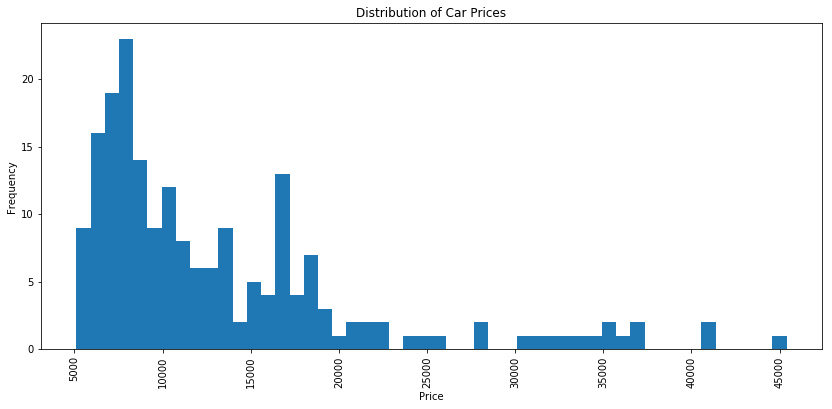

In [6]:
# Plot a histogram of car prices
plt.figure(figsize=(14,6))
auto_price.loc[:, 'price'].plot.hist(bins=50)
plt.xlabel('Price')
plt.title('Distribution of Car Prices')
plt.xticks(rotation = 'vertical')

Text(0, 0.5, 'Count')

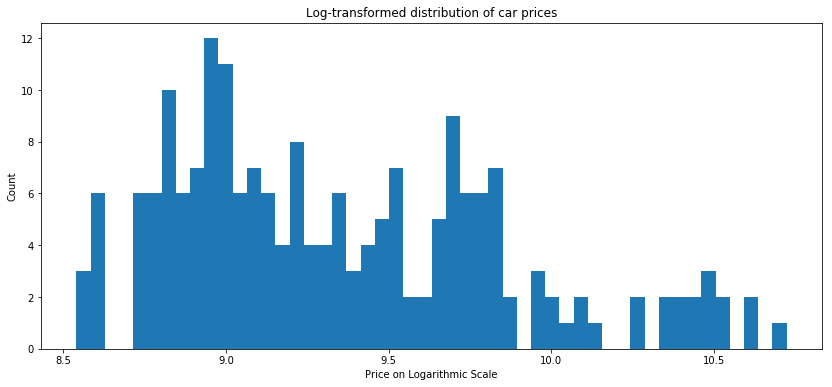

In [7]:
# Log transformation of car prices
xlog = auto_price.loc[:, 'log-price']
plt.figure(figsize=(14,6))
plt.hist(xlog, bins=50)
plt.title('Log-transformed distribution of car prices')
plt.xlabel('Price on Logarithmic Scale')
plt.ylabel('Count')

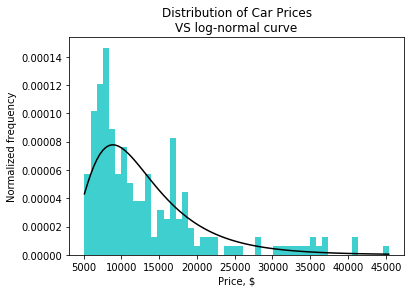

In [8]:
# From https://stackoverflow.com/questions/26406056/a-lognormal-distribution-in-python
data = auto_price.loc[:, 'price']
s, loc, scaling = scipy.stats.lognorm.fit(data, floc=0)
estimated_mu = np.log(scaling)
estimated_sigma = s
plt.hist(data, bins=50, density=True, color='c', alpha=0.75)
xmin = data.min()
xmax = data.max()
x = np.linspace(xmin, xmax, 100)
pdf = scipy.stats.lognorm.pdf(x, s, scale=scaling)
plt.title('Distribution of Car Prices\nVS log-normal curve')
plt.xlabel('Price, $')
plt.ylabel('Normalized frequency')
plt.plot(x, pdf, 'k')

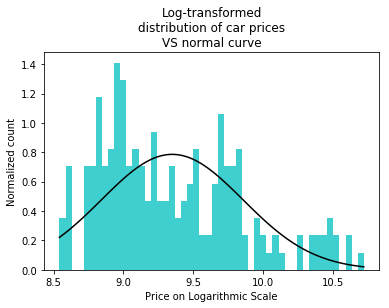

In [9]:
logdata = auto_price.loc[:, 'log-price']
plt.hist(logdata, bins=50, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = scipy.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.title('Log-transformed\ndistribution of car prices\nVS normal curve')
plt.xlabel('Price on Logarithmic Scale')
plt.ylabel('Normalized count')
plt.plot(x, pdf, 'k')

Text(0.5, 1.0, 'Q-Q plot of normal and log-transformed distributions')

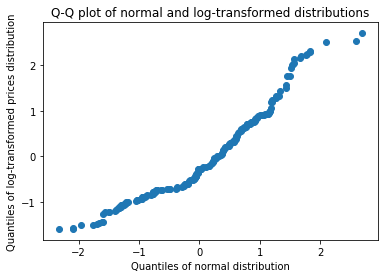

In [10]:
norm1 = nr.normal(size = len(logdata)).tolist()
norm2 = scale(logdata.tolist())
plt.scatter(x = sorted(norm1), y = sorted(norm2))
plt.xlabel('Quantiles of normal distribution')
plt.ylabel('Quantiles of log-transformed prices distribution')
plt.title('Q-Q plot of normal and log-transformed distributions')

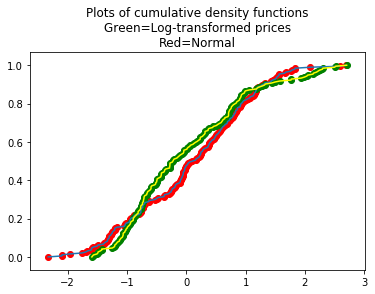

In [11]:
def plot_cums(dist1, dist2, plot_title = None):
    """Plot cdfs of the two distributions."""
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)
    
    plt.title(plot_title)

    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p)
    plt.scatter(data_sorted, p, color = 'red')
    
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    plt.plot(data_sorted, p, color = 'yellow')
    plt.scatter(data_sorted, p, color = 'green')

plot_title = 'Plots of cumulative density functions\nGreen=Log-transformed prices\nRed=Normal'
plot_cums(norm1, norm2, plot_title = plot_title)

In [12]:
def ks_test(dat, dist = 'norm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))
ks_test(norm2)    

KS-statistic = 0.10295537216792472
P-value = 0.029757993611015943


Because the p-value is less than the level of significance, alpha = 0.05, I must reject Ho that the log-transformed price data distribution is normal.

In [13]:
def ks_test(dat, dist = 'lognorm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist, [1.0])
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

ks_test(scale(data).tolist()) 

KS-statistic = 0.6644049924242191
P-value = 0.0


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


If I correctly adapted the ks_test() function to test the original price data for being log-normally distributed, then the p-value is 0, so I must reject the Ho that the original price data are log-normal. (The function adaptation includes the \[1\] parameter which I think represents 's' for sigma for the shape of the log-normal distribution.

#### The log-transformed prices are not exactly normal but, relying on the hint in the begining of this assignment, I'll consider this data to be kind of normal-ish.

## Log prices stratified by a) fuel type

In [14]:
# Get prices by fuel type
pop_D = get_log_prices(auto_price, 'fuel-type', 'diesel')
pop_G = get_log_prices(auto_price, 'fuel-type', 'gas')

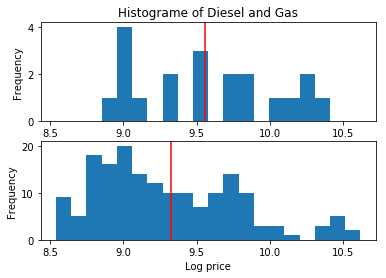

In [15]:
def hist_plot(vec, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Log price')
    
def plot_pop(a, b, cols=['pop_D', 'pop_G'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

plot_pop(pop_D, pop_G, cols = ['Diesel', 'Gas'])   

In [16]:
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

test = t_test(pop_D, pop_G, 0.05)
test

DegFreedom    23.941597
Difference     0.231544
Statistic      1.941036
PValue         0.053710
Low95CI       -0.007204
High95CI       0.470293
dtype: float64

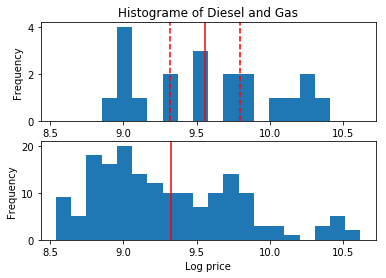

In [17]:
def hist_mean_ci(vec, t_test, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_D', 'pop_G'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

plot_t(pop_D, pop_G, test, cols = ['Diesel', 'Gas'])    

The difference in means is relatively small. The Confidence Interval includes zero. P-value is above a = 0.05. Therefore, I fail to reject the Null Hyposesis that the means of prices in gas and diesel categories are the same.

 ## Log price stratified by b) aspiration

In [18]:
# What aspiration types do I have?
auto_price['aspiration'].unique()

array(['std', 'turbo'], dtype=object)

In [19]:
pop_S = get_log_prices(auto_price, 'aspiration', 'std')
pop_T = get_log_prices(auto_price, 'aspiration', 'turbo')

In [20]:
test = t_test(pop_S, pop_T, 0.05)
test

DegFreedom    66.862750
Difference    -0.338868
Statistic     -3.724978
PValue         0.000256
Low95CI       -0.490113
High95CI      -0.187624
dtype: float64

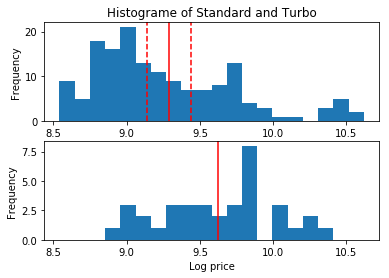

In [21]:
plot_t(pop_S, pop_T, test, cols = ['Standard', 'Turbo'])

Because the p-value is below a=0.05 and the C.I. does not include 0, I must reject the Null Hyposesis that there is no differences in prices stratified by aspiration.

## Log prices stratified by c) rear vs. front wheel drive

In [22]:
auto_price.loc[:, 'drive-wheels'].unique()

array(['rwd', 'fwd', '4wd'], dtype=object)

In [23]:
pop_R = get_log_prices(auto_price, 'drive-wheels', 'rwd')
pop_F = get_log_prices(auto_price, 'drive-wheels', 'fwd')

In [24]:
test = t_test(pop_S, pop_T, 0.05)
test

DegFreedom    66.862750
Difference    -0.338868
Statistic     -3.724978
PValue         0.000256
Low95CI       -0.490113
High95CI      -0.187624
dtype: float64

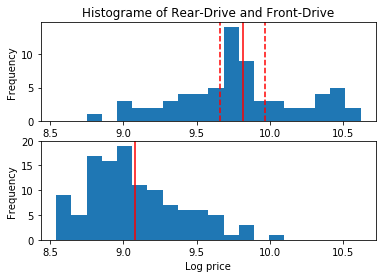

In [25]:
plot_t(pop_R, pop_F, test, cols = ['Rear-Drive', 'Front-Drive'])

Because the p-value is below a=0.05 and the C.I. does not include 0, I must reject the Null Hyposesis that there is no differences in prices stratified by the type of drive wheels of the auto.

## Apply ANOVA and Tukey's HSD test to the auto price data to compare the price (or log price if closer to a normal distribution) of autos stratified by body style

In [26]:
# What body styles are there?
auto_price['body-style'].unique()

array(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'],
      dtype=object)

In [27]:
b_style_convertible = auto_price.loc[auto_price['body-style'] == 'convertible'].loc[:, 'log-price']
b_style_hatchback = auto_price.loc[auto_price['body-style'] == 'hatchback'].loc[:, 'log-price']
b_style_sedan = auto_price.loc[auto_price['body-style'] == 'sedan'].loc[:, 'log-price']
b_style_wagon = auto_price.loc[auto_price['body-style'] == 'wagon'].loc[:, 'log-price']
b_style_hardtop = auto_price.loc[auto_price['body-style'] == 'hardtop'].loc[:, 'log-price']
all_styles = [b_style_convertible, b_style_hatchback, b_style_sedan, b_style_wagon, b_style_hardtop]
style_nums = [len(i) for i in all_styles]

In [28]:
# Number of values in each category
style_nums

[6, 63, 94, 24, 8]

Text(0.5, 1.0, 'Box plot of log prices by body styles')

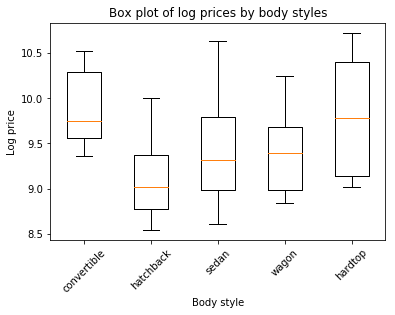

In [29]:
# Log prices of cars by body-style
style_names = ['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop']
plt.boxplot(all_styles)
plt.ylabel('Log price')
plt.xlabel('Body style')
plt.xticks(range(1, 6), labels = style_names, rotation = 45)
plt.title('Box plot of log prices by body styles')

In [30]:
# Anova analysis
f_statistic, p_value = scipy.stats.f_oneway(*all_styles)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 8.787539993678273
P-value = 1.5712433355094036e-06


Because the p-value is very small, I must reject Ho that there is no difference among prices by body-style.

In [31]:
# Tukey's HSD test
df = pd.DataFrame({'vals': list(itertools.chain.from_iterable(all_styles)),
                   'group_num': ['convertible'] * style_nums[0] 
                              + ['hatchback'] * style_nums[1] 
                              + ['sedan'] * style_nums[2] 
                              + ['wagon'] * style_nums[3]
                              + ['hardtop'] * style_nums[4]
                  })
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
   group1     group2  meandiff  lower   upper  reject
-----------------------------------------------------
convertible  hardtop  -0.0966  -0.7994  0.6061 False 
convertible hatchback -0.7854  -1.3413 -0.2294  True 
convertible   sedan   -0.4519  -0.9999  0.096  False 
convertible   wagon    -0.531  -1.1249  0.0629 False 
  hardtop   hatchback -0.6887  -1.1771 -0.2003  True 
  hardtop     sedan   -0.3553  -0.8345  0.1239 False 
  hardtop     wagon   -0.4344  -0.9656  0.0969 False 
 hatchback    sedan    0.3334   0.1216  0.5453  True 
 hatchback    wagon    0.2544  -0.0578  0.5665 False 
   sedan      wagon   -0.0791  -0.3767  0.2185 False 
-----------------------------------------------------


The Tukey's HSD test shows that the differences between the following groups are significant: convertible vs. hatchback; hardtop vs. hatchback; hatchback vs. sedan

## Graphically explore the differences between the price conditioned by the categories of each variable. 
Hint: Make sure you have enough data for each category and drop categories with insufficient data.
## Use standard ANOVA and Tukey HSD to test the differences of these groups.

I will explore one variable only as an example to show a slightly more streamlined process than the one I used above.

## Differences between the prices conditioned by fuel system

In [32]:
# What fuel system types are there?
unique_fuel_sys = auto_price.loc[:, 'fuel-system'].unique()
unique_fuel_sys

array(['mpfi', '2bbl', 'mfi', '1bbl', 'spfi', 'idi', 'spdi'], dtype=object)

In [33]:
# Get a list of fuel system type names and prices if the # of cases in each group excceds 5
all_fuel_sys = []
fuel_sys_names = []
for cat in unique_fuel_sys:
    price = get_log_prices(auto_price, 'fuel-system', cat)
    if len(price) > 5:
        fuel_sys_names.append(cat)
        all_fuel_sys.append(price)

In [34]:
print('# of cases in each category')
fuel_nums = [len(i) for i in all_fuel_sys]
fuel_nums

# of cases in each category


[89, 64, 11, 20, 9]

Text(0.5, 1.0, 'Box plot of prices by fuel system type')

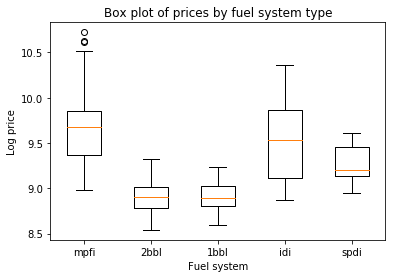

In [35]:
# Log prices of cars by fuel system type
plt.boxplot(all_fuel_sys)
plt.ylabel('Log price')
plt.xlabel('Fuel system')
plt.xticks(range(1, 6), labels = fuel_sys_names)
plt.title('Box plot of prices by fuel system type')

In [36]:
f_statistic, p_value = scipy.stats.f_oneway(*all_fuel_sys)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 51.73774505019595
P-value = 2.4943561838682617e-29


Because the p-value is very small, I must reject Ho that there is no difference among the mean prices by fuel system type.

In [37]:
df = pd.DataFrame({'vals': list(itertools.chain.from_iterable(all_fuel_sys)),
                   'group_num': [fuel_sys_names[0]] * fuel_nums[0] 
                              + [fuel_sys_names[1]] * fuel_nums[1] 
                              + [fuel_sys_names[2]] * fuel_nums[2] 
                              + [fuel_sys_names[3]] * fuel_nums[3]
                              + [fuel_sys_names[4]] * fuel_nums[4]
                  })
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 1bbl   2bbl   -0.018  -0.3387  0.3026 False 
 1bbl   idi    0.6424   0.2736  1.0112  True 
 1bbl   mpfi   0.7735   0.4596  1.0875  True 
 1bbl   spdi   0.362   -0.0796  0.8035 False 
 2bbl   idi    0.6604   0.4088  0.9121  True 
 2bbl   mpfi   0.7916   0.6306  0.9526  True 
 2bbl   spdi    0.38    0.0303  0.7297  True 
 idi    mpfi   0.1311   -0.112  0.3743 False 
 idi    spdi  -0.2804  -0.6748  0.1139 False 
 mpfi   spdi  -0.4116  -0.7552 -0.0679  True 
---------------------------------------------


The above table shows which groups have significantly different means.